# Essais avec les données du Allen Institute

## Exemple type d'expérience
* __Analyse 1__
    1. Choisir une région du cerveau à étudier.

    2. Recupérer les expériences du Allen pour lesquelles il y a beaucoup de fluorescence à cet endroit. 

    3. Télécharger les volumes du Allen correpondants

    4. Aligner sur nos cerveaux de référence

    5. Intégrer ces volumes au SBH-Assistant (pour aider les utilisateurs du microscope à cibler les régions où on s'attend à avoir beaucoup de signal.)

* __Analyse 2__ 
    1. Proposer des lieux d'injections
    
    2. Obtenir du signal dans notre région ciblée. 

# Mouse Connectivity Cache

## Recherche par liste de régions d'injection (cache)

In [ ]:
# exemple sur les injections à l'isocortex
import pandas as pd
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

mcc = MouseConnectivityCache()

structure_tree = mcc.get_structure_tree()
isocortex_id = structure_tree.get_structures_by_name(['Isocortex'])[0]['id']                             
injection_regions_ids = [isocortex_id]

experiments = mcc.get_experiments(dataframe=True, injection_structure_ids=injection_regions_ids)
print("%d total experiments" % len(experiments))

experiments

## Recherche par coordonnées d'injection (cache)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

def load_allen_experiments():
    # open up a list of all of the experiments
    return MouseConnectivityCache().get_experiments(dataframe=True)

def get_id_from_injection_coord(injection_coord):#(x,y,z):
    #injection_coord = [x, y, z]
    all_experiments = load_allen_experiments()
    experiment_id = all_experiments.index[all_experiments['injection-coordinates'].map(set(injection_coord).issubset)].tolist() 
    return experiment_id[0]

def get_projection_density(experiment_id):
    pd, pd_info = mcc.get_projection_density(experiment_id)
    # compute the maximum intensity projection (along the anterior-posterior axis) of the projection data
    pd_mip_x = pd.max(axis=0)
    pd_mip_y = pd.max(axis=1)
    f, pr_axes = plt.subplots(1, 2, figsize=(15, 6))
    pr_axes[0].imshow(pd_mip_x, cmap='hot', aspect='equal')
    pr_axes[0].set_title("projection density MaxIP")
    pr_axes[1].imshow(pd_mip_y, cmap='hot', aspect='equal')
    pr_axes[1].set_title("projection density MaxIP")
    plt.show()
    return

load_allen_experiments()
experiment_id = get_id_from_injection_coord([5520, 4470, 10080])
get_projection_density(experiment_id)

## Liste des régions du cerveau

In [91]:
import pandas as pd
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

structure_tree = MouseConnectivityCache().get_structure_tree()
summary_structures =  structure_tree.get_structures_by_set_id([167587189])
pd.DataFrame(summary_structures)[['acronym','name','id']].tail(8)

,acronym,name,id
308,COPY,Copula pyramidis,1033
309,PFL,Paraflocculus,1041
310,FL,Flocculus,1049
311,FN,Fastigial nucleus,989
312,IP,Interposed nucleus,91
313,DN,Dentate nucleus,846
314,VeCB,Vestibulocerebellar nucleus,589508455
315,fiber tracts,fiber tracts,1009


# Mouse Connectivity API

## Recherche par régions (API)

In [29]:
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

# get metadata for all experiments in specific regions
    # create a list of regions
injection_regions = ['FRP','IP']

    # API request on this link http://api.brain-map.org/api/v2/data/query.xml?criteria=service::mouse_connectivity_injection_coordinate[seed_point$eq5520,4470,10080]
experiments = mca.experiment_source_search(injection_structures=injection_regions)

    # display the experiments
pd.DataFrame(experiments)[['id','injection-volume','structure-abbrev']].head()

,id,injection-volume,structure-abbrev
0,100140756,0.156190,FRP
1,304474221,0.261310,IP
2,268389532,0.159990,IP
3,293433996,0.190371,FRP
4,286299886,0.093602,FRP


## Recherche par proximité d'une région d'injection (API)

In [71]:
# experiment_injection_coordinate_search (regions d'injections)
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

# get metadata for all experiments near the injection coordinates
    # configure the coordinates
x = 5520
y = 4470
z = 10080
injection_coordinates = [x, y, z]

    # API request on this link http://api.brain-map.org/api/v2/data/query.xml?criteria=service::mouse_connectivity_injection_coordinate[seed_point$eq5520,4470,10080]
nearby_experiment = mca.experiment_injection_coordinate_search(seed_point=injection_coordinates)

    # display the experiments
list_of_distances = pd.DataFrame(nearby_experiment).distance
print(list_of_distances.head())
pd.DataFrame(nearby_experiment)[['id','distance','injection-volume','injection-coordinates']].head(10)


0      0.000000
1    508.527285
2    540.555270
3    548.543526
4    685.930026
Name: distance, dtype: float64


,id,distance,injection-volume,injection-coordinates
0,180436360,0.000000,1.135290,"[5520, 4470, 10080]"
1,113036264,508.527285,0.553939,"[5810, 4780, 9800]"
2,286775476,540.555270,0.279911,"[5930, 4760, 9880]"
3,174361746,548.543526,0.449952,"[6040, 4400, 10240]"
4,174360333,685.930026,0.223101,"[4920, 4350, 9770]"
5,297858011,708.025423,0.024480,"[5590, 4870, 9500]"
6,508373923,711.758386,0.004450,"[6190, 4230, 10090]"
7,168095756,738.850458,0.000816,"[5770, 4920, 9550]"
8,297945448,772.398861,0.142637,"[5780, 3780, 9850]"
9,180404418,792.022727,0.007727,"[5260, 4360, 9340]"


## Recherche par zone à forte densité de projection (API)

In [82]:
# experiment_spatial_search (densité)
import pandas as pd
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

mca = MouseConnectivityApi()

# get metadata for all experiments with high density near the injection coordinate
    # configure the coordinates
x = 5520
y = 4470
z = 10080
injection_coordinates = [x, y, z]

    # API request http://api.brain-map.org/api/v2/data/query.xml?criteria=service::mouse_connectivity_target_spatial[seed_point$eqx,y,z]
sections_data_sets = mca.experiment_spatial_search(seed_point=injection_coordinates)

    # display the experiments
list_of_density = pd.DataFrame(sections_data_sets).density
path_along_most_dense_pixel_id1 = pd.DataFrame(sections_data_sets).path[1]

#print(list_of_density.head(),path_along_most_dense_pixel_id1)

for pixel in path_along_most_dense_pixel_id1:
    if pixel['intensity'] > 0 and pixel['density'] >= 0.09: 
        print(pixel)

df = pd.DataFrame(sections_data_sets)[['density','injection-volume','projection','path']]

"""
for path in df['path']:
    for pixel in path:
        if pixel['intensity'] > 0 and pixel['density'] >= 0.1: 
            print(pixel['coord'],", ",pixel['density'],", ",pixel['intensity'])
"""
pd.DataFrame(sections_data_sets)[['id','density','injection-volume','projection','injection-coordinates']].head(10)


{'coord': [5200.0, 4100.0, 9200.0], 'density': 0.09509018063545227, 'intensity': 2293.598876953125}


,id,density,injection-volume,projection,injection-coordinates
0,272827141,0.131948,0.104110,0.131836,"[6020, 3820, 9380]"
1,286838022,0.028094,0.041925,0.028320,"[5390, 3560, 8980]"
2,299783689,0.258777,0.695015,0.258789,"[4420, 4070, 9060]"
3,551350026,0.011534,0.223544,0.011719,"[4450, 5750, 8230]"
4,174360333,0.223838,0.223101,0.223633,"[4920, 4350, 9770]"
5,182280207,0.068109,0.173941,0.068359,"[9480, 4060, 5670]"
6,294397199,0.106985,0.336656,0.107422,"[4420, 2970, 9130]"
7,553446684,0.048221,0.014138,0.047852,"[5960, 3980, 9630]"
8,157654817,0.094868,0.138259,0.094727,"[4370, 3460, 9310]"
9,159552290,0.035296,0.196300,0.035156,"[6240, 3380, 9210]"


# Reference Space API

## Essais et Tests avec la documentation

2022-04-27 14:55:58,319 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_1049.nrrd


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

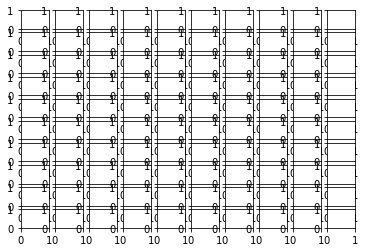

In [145]:
from allensdk.api.queries.reference_space_api import ReferenceSpaceApi
import matplotlib.pyplot as plt

rspa = ReferenceSpaceApi()

resolution = rspa.VOXEL_RESOLUTION_25_MICRONS
id = 1049 # Flocculus
path = "/Users/mahdi/stage-2022-mahdi/src/test_structure_mask"
vesion = 'annotation/ccf_2017'
structure_mask = rspa.download_structure_mask(
    ccf_version=vesion,
    structure_id=id,
    resolution=resolution,
    file_name=path)

# view 
i = 400
nrows = 10
ncols = 10
fig, axs = plt.subplots(nrows,ncols)
for r in range(nrows):
    for c in range(ncols):
        axs[r,c].imshow(structure_mask[0][i,:], interpolation='none', cmap=plt.cm.afmhot)
        i+=1
       